<a href="https://colab.research.google.com/github/bereml/riiaa-19-dmtl/blob/master/notebooks/4_cnn_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solución: red convolucional

#### <div style="text-align: right"> Berenice Montalvo Lezama </div>

El objetivo es extender el ejercicio anterior y entrenar un modelo que pueda predecir las diez posibles etiquetas en el conjunto de datos considerando cada predicción como una tarea de clasificación binaria.

![Recipes5k](https://raw.githubusercontent.com/richardtml/riiaa-19-dmtl/master/figs/recipes2k_multilabel.png)

Para la solución debemos actualizar:
1. la carga de datos,
2. la salida de la arquitectura y 
3. la inferencia (etiquetas).

Como extra podemos:
1. modificar la arquitectura agreagando más capas (capacidad) y
2. experimentar con otros ejemplos en el conjunto de prueba.

## 1 Carga de datos

### 1.1 Importando bibliotecas

In [1]:
# para cargar Tensorflow 2 en Colab
try:
  %tensorflow_version 2.x
except Exception:
  pass


import os
# listar el sistema de archivos
import glob

# graficación
import matplotlib.pyplot as plt
# lectura de csv
import pandas as pd
# redes neuronales
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D


# fijamos una semilla para reproducibilidad
tf.random.set_seed(42)

### 1.2 Descarga de los datos

In [2]:
tf.keras.utils.get_file('recipes2k.tar.gz',
    'https://cloud.xibalba.com.mx/s/AmF7Xa8F522qZnX/download',
    extract=True)
!ls ~/.keras/datasets/recipes2k

test  train  train.csv


### 1.3 Lectura de rutas y etiquetas

In [3]:
# leemos las rutas de las imágenes
images_paths = sorted(glob.glob(os.path.expanduser('~/.keras/datasets/recipes2k/train/*/*.jpg')))
images_paths[:5]

['/home/richardt/.keras/datasets/recipes2k/train/apple_pie/0_spiced_apple_lattice_pie.jpg',
 '/home/richardt/.keras/datasets/recipes2k/train/apple_pie/10_apple_pie.jpg',
 '/home/richardt/.keras/datasets/recipes2k/train/apple_pie/11_classic_apple_pie.jpg',
 '/home/richardt/.keras/datasets/recipes2k/train/apple_pie/12_magically_fast_apple_pie.jpg',
 '/home/richardt/.keras/datasets/recipes2k/train/apple_pie/13_mug_apple_pie.jpg']

In [4]:
# leemos el csv de etiquetas
df = pd.read_csv('~/.keras/datasets/recipes2k/train.csv', sep=',')
df.head(5)

,item,healthy,junk,dessert,appetizer,mains,soups,carbs,protein,fats,meat
0,apple_pie,0,0,1,0,0,0,1,0,1,0
1,baby_back_ribs,0,0,0,0,1,0,0,1,1,1
2,beef_tacos,0,0,0,0,1,0,1,1,1,1
3,beet_salad,1,0,0,0,1,0,0,1,0,0
4,bread_pudding,0,0,1,0,0,0,1,0,1,0


In [5]:
# armamos un diccionario con la clase como llave y la primera etiqueta como valor  
labels_dict = {row[0]: row[1:] for row in df.values}
# armamos una lista de de etiquetas para las rutas 
labels = [labels_dict[p.split('/')[-2]] for p in images_paths] 
labels[:5]

[array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=object),
 array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=object),
 array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=object),
 array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=object),
 array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=object)]

### 1.4 Tuberia de datos

In [6]:
# tamaño a redimensionar para la imagen 
IMG_SIZE = (64, 64)
# función de lectura que toma una ruta y devuelve una imagen
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image /= 255.0
    return image


shuffle_size = len(images_paths)
batch_size = 64
# cargamos las rutas en un Dataset
images_ds = tf.data.Dataset.from_tensor_slices(images_paths)
# cargamos las imágenes de las rutas
images_ds = images_ds.map(read_image, num_parallel_calls=4)
# Dataset para las etiquetas
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
# emparejamos los Datasets
ds = tf.data.Dataset.zip((images_ds, labels_ds))
# barajeamos
ds = ds.shuffle(shuffle_size)
# empaquetamos por lotes
ds = ds.batch(batch_size)

# imprimimos las dimensiones y un ejemplo
for x, y_true in ds:
    print('x.shape={}'.format(x.shape))
    print('x[0, :2, :2, 0]={}'.format(x[0, :2, :2, 0]))
    print('y_true.shape={}'.format(y_true.shape))
    print('y_true[0]={}'.format(y_true[0]))
    break

W0829 00:26:27.450838 140496738711360 deprecation.py:323] From /home/richardt/.virtualenvs/riiaa/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


x.shape=(64, 64, 64, 3)
x[0, :2, :2, 0]=[[0.3920037  0.34561887]
 [0.33314952 0.39635417]]
y_true.shape=(64, 10)
y_true[0]=[0 0 0 0 1 0 1 0 1 0]


### 1.5 Exploración

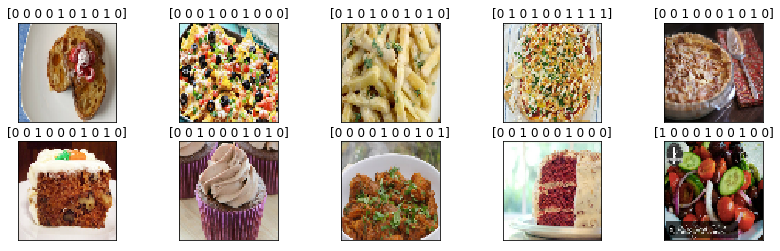

In [7]:
fig = plt.figure(figsize=(14, 4))
for i, (x, y_true) in enumerate(ds, start=1):
    ax = fig.add_subplot(2, 5, i)
    image = x[0]
    labels = str(y_true[0].numpy())
    ax.imshow(image)
    ax.set_title(labels)
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 10:
        break

## 2 Implementación del modelo

In [8]:
class VanillaCNN(tf.keras.Model):

  def __init__(self):
    super(VanillaCNN, self).__init__()
    self.conv1 = Conv2D(8, 3, padding='same')
    self.pool1 = MaxPooling2D(pool_size=2, padding='same')
    self.conv2 = Conv2D(16, 3, padding='same')
    self.pool2 = MaxPooling2D(pool_size=2, padding='same')
    self.conv3 = Conv2D(32, 3, padding='same')
    self.pool3 = MaxPooling2D(pool_size=2, padding='same')
    self.conv4 = Conv2D(64, 3, padding='same')
    self.pool4 = MaxPooling2D(pool_size=2, padding='same')
    self.flat = Flatten()
    self.fc = Dense(10)

  def call(self, x):
    #####################
    # (N, 64, 64, 3) =>
    # (N, 64, 64, 8)
    x = self.conv1(x)
    # (N, 64, 64, 8) =>
    # (N, 32, 32, 8)
    x = self.pool1(x)
    # (N, 32, 32, 8)
    x = tf.nn.relu(x)
    #####################
    # (N, 32, 32, 8) =>
    # (N, 32, 32, 16)
    x = self.conv2(x)
    # (N, 32, 32, 16) =>
    # (N, 16, 16, 16)
    x = self.pool2(x)
    # (N, 16, 16, 16)
    x = tf.nn.relu(x)
    #####################
    # (N, 16, 16, 16) =>
    # (N, 16, 16, 32)
    x = self.conv3(x)
    # (N, 16, 16, 32) =>
    # (N, 8, 8, 32)
    x = self.pool3(x)
    # (N, 8, 8, 32)
    x = tf.nn.relu(x)
    #####################
    # (N, 8, 8, 32) =>
    # (N, 8*8*32)
    x = self.flat(x)
    #####################
    # (N, 8*8*32) =>
    # (N, 1)
    x = self.fc(x)
    # (N, 1)
    x = tf.nn.sigmoid(x)
    return x

## 3 Entrenamiento

### 3.1 Función de pérdida y optimizador

In [9]:
# entropía cruzada binaria
loss_fn = tf.keras.losses.BinaryCrossentropy()
# gradiente descendente
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

### 3.2 Métricas: pérdida y exactitud

In [10]:
# historiales a nivel época
loss_epoch = tf.keras.metrics.Mean()
acc_epoch = tf.keras.metrics.BinaryAccuracy()

# historiales a nivel entrenamiento
loss_history = []
acc_history = []

### 3.3 Ciclo de entrenamiento

In [11]:
# instanciamos el modelo
model = VanillaCNN()

# épocas de entrenamiento
for epoch in range(30):
    # pasos de entrenamiento
    for step, (x, y_true) in enumerate(ds):
    
        # registramos el flujo del cómputo en GradientTape
        with tf.GradientTape() as tape:
            
            # realizamos inferencia con el lote 
            y_pred = model(x)
            # computamos la pérdia
            loss = loss_fn(y_true, y_pred)
        
        # computamos los gradientes de los parámetros del modelo
        gradients = tape.gradient(loss, model.trainable_weights)
        # aplicamos los gradientes
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        # calculamos las métricas y agramos al historial de la época
        loss_epoch(loss)
        acc_epoch(y_true, y_pred)
    
    # guardamos las métricas de la época
    loss_epoch_res = loss_epoch.result().numpy() * 100
    acc_epoch_res = acc_epoch.result().numpy() * 100
    
    # reiniciamos los historiales de las épocas
    loss_epoch.reset_states()
    acc_epoch.reset_states()
    
    # agreagmos a los historiales nivel entrenamiento
    loss_history.append(loss_epoch_res)
    acc_history.append(acc_epoch_res)
    
    # imprimimos métricas
    print('{:2d} loss={:6.2f}, acc={:6.2f}'.format(
        epoch, loss_epoch_res, acc_epoch_res))

 0 loss= 57.59, acc= 70.83
 1 loss= 55.88, acc= 72.02
 2 loss= 54.76, acc= 72.58
 3 loss= 53.81, acc= 73.08
 4 loss= 53.05, acc= 73.57
 5 loss= 52.22, acc= 74.19
 6 loss= 51.28, acc= 74.85
 7 loss= 50.50, acc= 75.32
 8 loss= 49.85, acc= 75.62
 9 loss= 49.02, acc= 76.10
10 loss= 48.08, acc= 76.81
11 loss= 47.24, acc= 77.43
12 loss= 46.34, acc= 77.88
13 loss= 45.35, acc= 78.34
14 loss= 44.34, acc= 78.93
15 loss= 43.26, acc= 79.55
16 loss= 42.18, acc= 80.33
17 loss= 41.10, acc= 80.95
18 loss= 39.98, acc= 81.61
19 loss= 38.76, acc= 82.41
20 loss= 37.56, acc= 83.04
21 loss= 36.32, acc= 83.84
22 loss= 35.15, acc= 84.52
23 loss= 33.90, acc= 85.23
24 loss= 32.73, acc= 85.80
25 loss= 31.65, acc= 86.35
26 loss= 30.72, acc= 86.84
27 loss= 29.82, acc= 87.24
28 loss= 29.09, acc= 87.56
29 loss= 28.52, acc= 87.87


### 3.4 Gráfica de pérdida

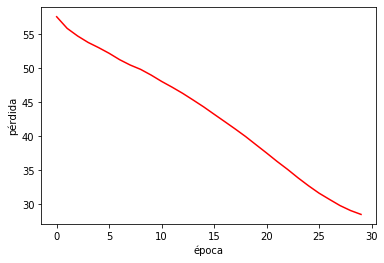

In [12]:
plt.plot(loss_history, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

### 3.5 Gráfica de exactitud

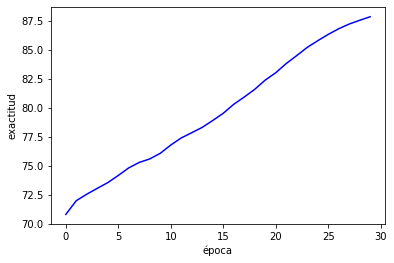

In [13]:
plt.plot(acc_history, color='blue')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## 4 Prueba de la vitamina T

### 4.1 Tuberia de datos

In [14]:
images_paths = sorted(glob.glob(os.path.expanduser('~/.keras/datasets/recipes2k/test/*.jpg')))
images_ds = tf.data.Dataset.from_tensor_slices(images_paths).map(read_image, num_parallel_calls=4)
ds = tf.data.Dataset.zip(images_ds).shuffle(shuffle_size).batch(1)

### 4.2 Inferencia

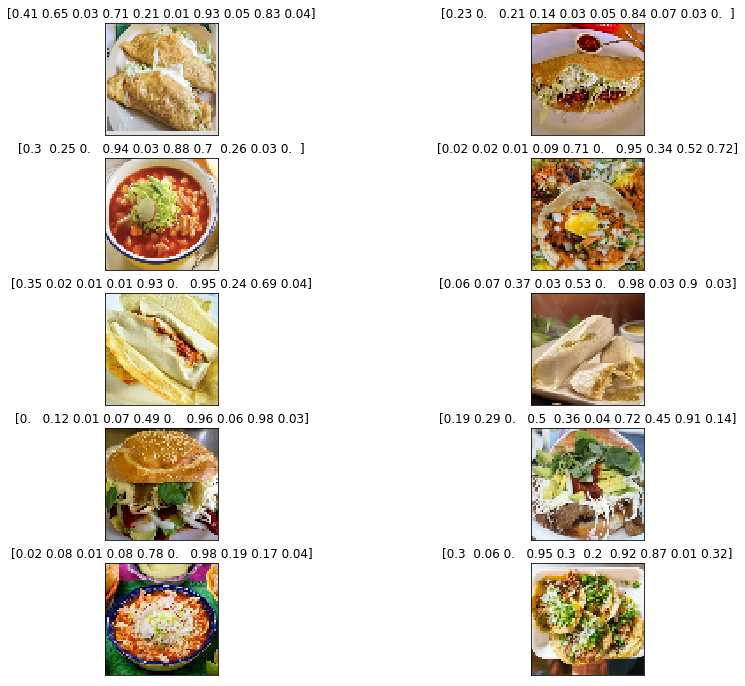

In [15]:
fig = plt.figure(figsize=(14, 12))
for i, (x) in enumerate(ds, start=1):
    ax = fig.add_subplot(5, 2, i)
    image = x[0]
    y_pred = model(x)
    labels = str(y_pred[0].numpy().round(decimals=2))
    ax.imshow(image)
    ax.set_title(labels)
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 10:
        break